# Laboratorium 3: Analiza wrażliwości

**Imię i nazwisko:** Anna Bernard, Mikołaj Mieszko Charchuta 
**Grupa:**  Symulanci
**Data wykonania:**  29.05.2025

---

## 1. Wstęp

W tym laboratorium podjęliśmy się prób oceny wrażliwości lokalnej (opartej o funkcje wrażliwości) 
i globalnej (opartej o wskaźniki Sobola).

## 2. Opis zaimplementowanego rozwiązania

- **Wariant implementacji:** RK4 ze stałym krokiem, ręcznie wpisane pochodne
- **Biblioteki użyte:** matplotlib, SALib
- **Model:** Wrażliwość symulacji dynamiki białek p53, MDMcyto, MDMn, PTEN na zmiany parametrów reakcji w dwóch scenariuszach biologicznych
- **Horyzont czasowy:** 48 godzin (2880 minut)
- **Krok całkowania:** 6 minut
- **Wprowadzanie danych:** Przyjęcie domyślnych

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [49]:
def f_p53(params, p53, mdmn): 
    return params['p1'] - params['d1'] * p53 * (mdmn**2)

def f_mdmcyto(params, p53, mdmcyto, pten, siRNA=False, no_DNA_damage=False):
    siRNA_factor = value_siRNA if siRNA else 1
    DNA_damage_factor = value_no_DNA_damage if no_DNA_damage else 1
    return (params['p2'] * siRNA_factor * (p53**4) / ((p53**4) + (params['k2']**4))
            - params['k1'] * (params['k3']**2) / ((params['k3']**2) + (pten**2)) * mdmcyto
            - params['d2'] * DNA_damage_factor * mdmcyto)

def f_mdmn(params, mdmn, mdmcyto, pten, no_DNA_damage=False):
    if no_DNA_damage:
        return (params['k1'] * (params['k3']**2) / ((params['k3']**2) + (pten**2)) * mdmcyto
                - params['d2'] * value_no_DNA_damage * mdmn)
    else:
        return (params['k1'] * (params['k3']**2) / ((params['k3']**2) + (pten**2)) * mdmcyto
                - params['d2'] * mdmn)

def f_pten(params, pten, p53, pten_off=False):
    if not pten_off:
        return (params['p3'] * (p53**4) / ((p53**4) + (params['k2']**4))
                - params['d3'] * pten)
    else:
        return - params['d3'] * pten
        # return (params['p3'] * value_PTEN_off * (p53**4) / ((p53**4) + (params['k2']**4))
        #         - params['d3'] * pten)

    
# Pochodne tych funkcji(?):

# RK4 ze stałym krokiem
def RK4const(params, p53, mdcyto, mdmn, pten, h, siRNA=False, pten_off=False, no_DNA_damage=False):
    k1_p53 = f_p53(params, p53, mdmn)
    k1_mdmcyto = f_mdmcyto(params, p53, mdcyto, pten, siRNA)
    k1_mdmn = f_mdmn(params, mdmn, mdcyto, pten)
    k1_pten = f_pten(params, pten, p53, pten_off)

    k2_p53 = f_p53(params, p53 + h/2*k1_p53, mdmn + h/2*k1_mdmn)
    k2_mdmcyto = f_mdmcyto(params, p53 + h/2*k1_p53, mdcyto + h/2*k1_mdmcyto, pten + h/2*k1_pten, siRNA)
    k2_mdmn = f_mdmn(params, mdmn + h/2*k1_mdmn, mdcyto + h/2*k1_mdmcyto, pten + h/2*k1_pten)
    k2_pten = f_pten(params, pten + h/2*k1_pten, p53 + h/2*k1_p53, pten_off)

    k3_p53 = f_p53(params, p53 + h/2*k2_p53, mdmn + h/2*k2_mdmn)
    k3_mdmcyto = f_mdmcyto(params, p53 + h/2*k2_p53, mdcyto + h/2*k2_mdmcyto, pten + h/2*k2_pten, siRNA)
    k3_mdmn = f_mdmn(params, mdmn + h/2*k2_mdmn, mdcyto + h/2*k2_mdmcyto, pten + h/2*k2_pten)
    k3_pten = f_pten(params, pten + h/2*k2_pten, p53 + h/2*k2_p53, pten_off)

    k4_p53 = f_p53(params, p53 + h*k3_p53, mdmn + h*k3_mdmn)
    k4_mdmcyto = f_mdmcyto(params, p53 + h*k3_p53, mdcyto + h*k3_mdmcyto, pten + h*k3_pten, siRNA)
    k4_mdmn = f_mdmn(params, mdmn + h*k3_mdmn, mdcyto + h*k3_mdmcyto, pten + h*k3_pten)
    k4_pten = f_pten(params, pten + h*k3_pten, p53 + h*k3_p53, pten_off)


    p53 += (k1_p53 + 2*k2_p53 + 2*k3_p53 + k4_p53) * h / 6
    mdcyto += (k1_mdmcyto + 2*k2_mdmcyto + 2*k3_mdmcyto + k4_mdmcyto) * h / 6
    mdmn += (k1_mdmn + 2*k2_mdmn + 2*k3_mdmn + k4_mdmn) * h / 6
    pten += (k1_pten + 2*k2_pten + 2*k3_pten + k4_pten) * h / 6
    return p53, mdcyto, mdmn, pten

## 3. Parametry symulacji i scenariusze

In [3]:
# Warunki początkowe zgodnie z liczbą cząsteczek w hepatocycie:
p53_0 = 102000
mdmcyto_0 = 205000
mdmn_0 = 205000
pten_0 = 614000
proteins = [p53_0, mdmcyto_0, mdmn_0, pten_0] 

h = 6 # krok czasowy w minutach
iterations = int(48*60/h) # liczba iteracji na 48h
conditions = { 
        "Basic" : (False, False, True), # siRNA, PTEN_off, no_DNA_damage
        "Tumor" : (False, True, False),
}
scenarios = list(conditions.keys())

params = {
    'p1': 8.8,
    'p2': 440,
    'p3': 100,
    'd1': 1.375e-14,
    'd2': 1.375e-4,
    'd3': 3e-5,
    'k1': 1.925e-4,
    'k2': 1e5,
    'k3': 1.5e5
    }
value_siRNA = 0.02,
value_PTEN_off = 0,
value_no_DNA_damage = 0.1


## 4. Wyniki symulacji: RK4 (stały krok)

In [4]:
def RK4(params, proteins, scenario, iterations, h):
    siRNA, pten_off, no_DNA_damage = scenario
    p53, mdmcyto, mdmn, pten = proteins
    time_values = []
    p53_values = []
    mdmcyto_values = []
    mdmn_values = []
    pten_values = []
    for i in range(iterations):
        time = i * h
        time_values.append(time)
        p53_values.append(p53)
        mdmcyto_values.append(mdmcyto)
        mdmn_values.append(mdmn)
        pten_values.append(pten)
        p53, mdmcyto, mdmn, pten = RK4const(params, p53, mdmcyto, mdmn, pten, h, siRNA, pten_off, no_DNA_damage)
    return time_values, [p53_values, mdmcyto_values, mdmn_values, pten_values]

In [5]:
def local_sensitivity(params_nominal, proteins, scenario, delta=1e-4):
    t, y_nom = RK4(params, proteins, scenario, iterations, h)
    p53_nom = np.array(y_nom[0]) 
    
    sensitivities = {}
    for key in params_nominal:
        params_perturbed = params_nominal.copy()
        perturb = params_nominal[key] * delta if params_nominal[key] != 0 else delta
        params_perturbed[key] += perturb
        t, y_perturbed = RK4(params_perturbed, proteins, scenario, iterations, h)
        p53_perturbed = np.array(y_perturbed[0])
        S = (p53_perturbed - p53_nom) / perturb
        # Normalizacja
        S_norm = (params_nominal[key]/p53_nom) * S
        sensitivities[key] = S_norm.tolist()
    return t, sensitivities, p53_nom


W funkkcji poniżej, do rankingu bierzemy wartości bezwzględne z obliczonej średniej  wrażliwości dla każdego parametru

In [11]:
def ranking(sensitivities):
    r1 = {k: np.mean(v)  for k, v in sensitivities.items()}
    ranked1 = sorted(r1.items(), key=lambda item: np.abs(item[1]), reverse=True)
    r2 = {k: v[-1] for k, v in sensitivities.items()}
    ranked2 = sorted(r2.items(), key=lambda item: np.abs(item[1]), reverse=True)
    return ranked1, ranked2

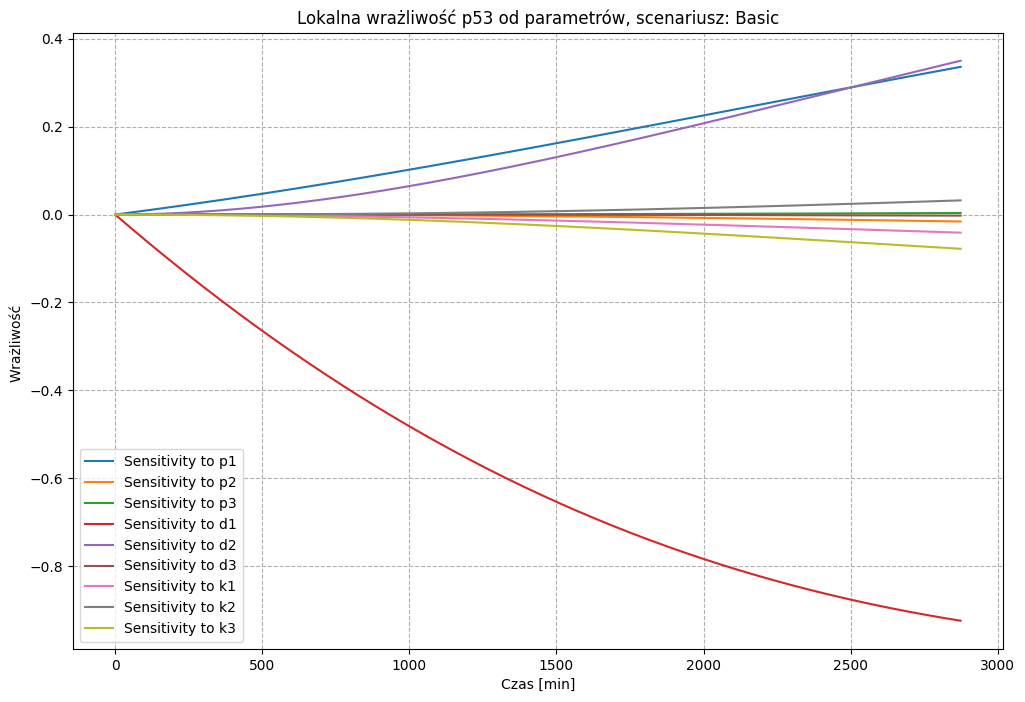

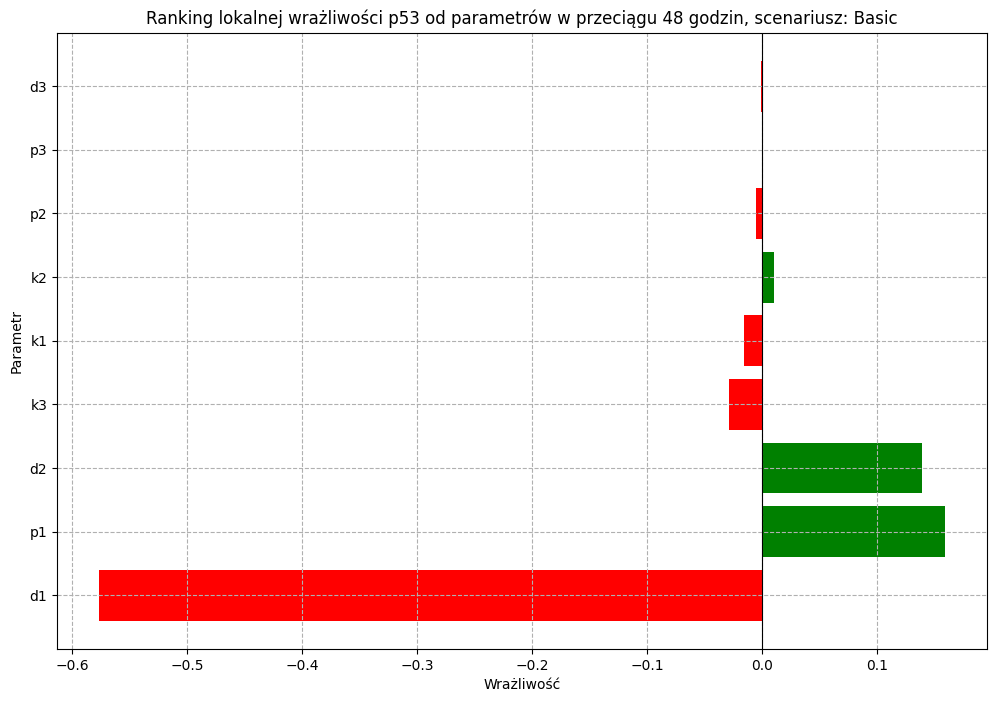

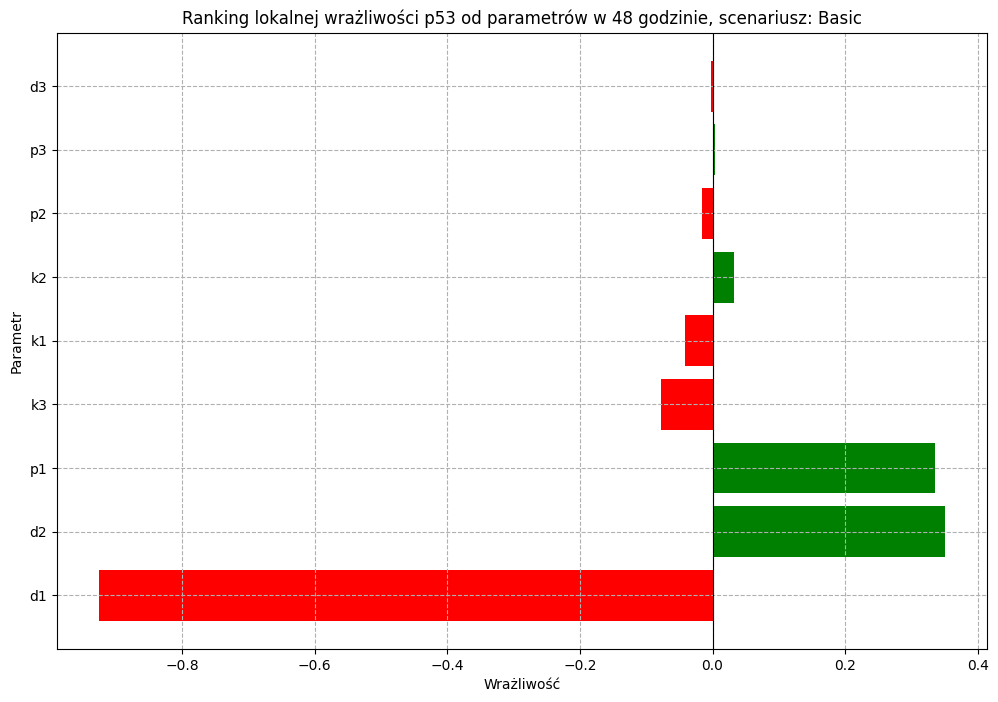

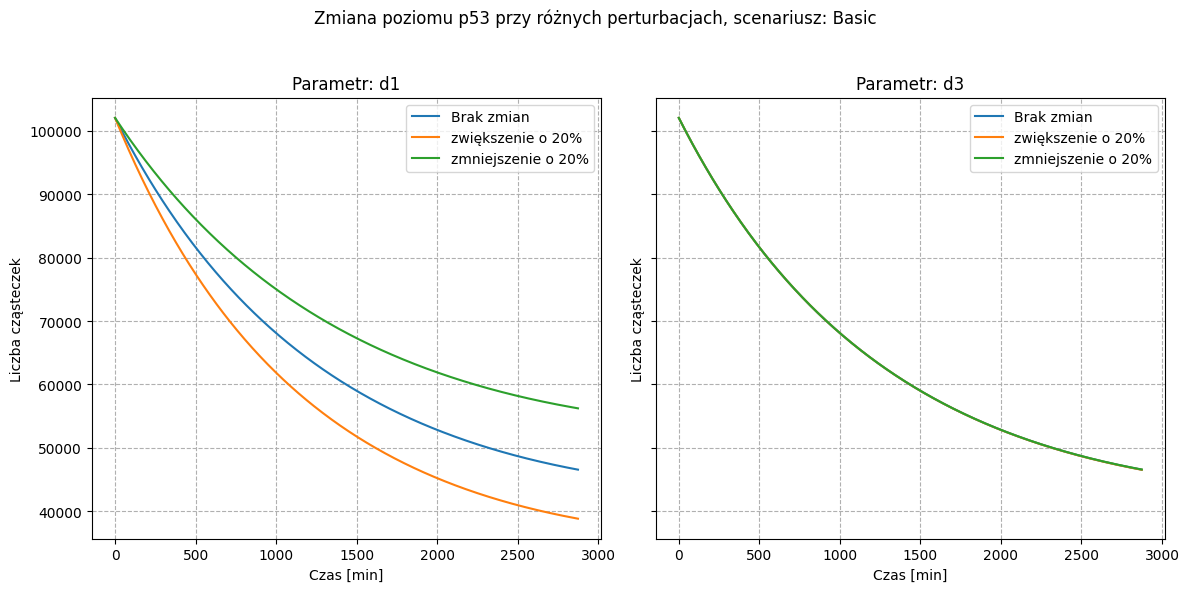

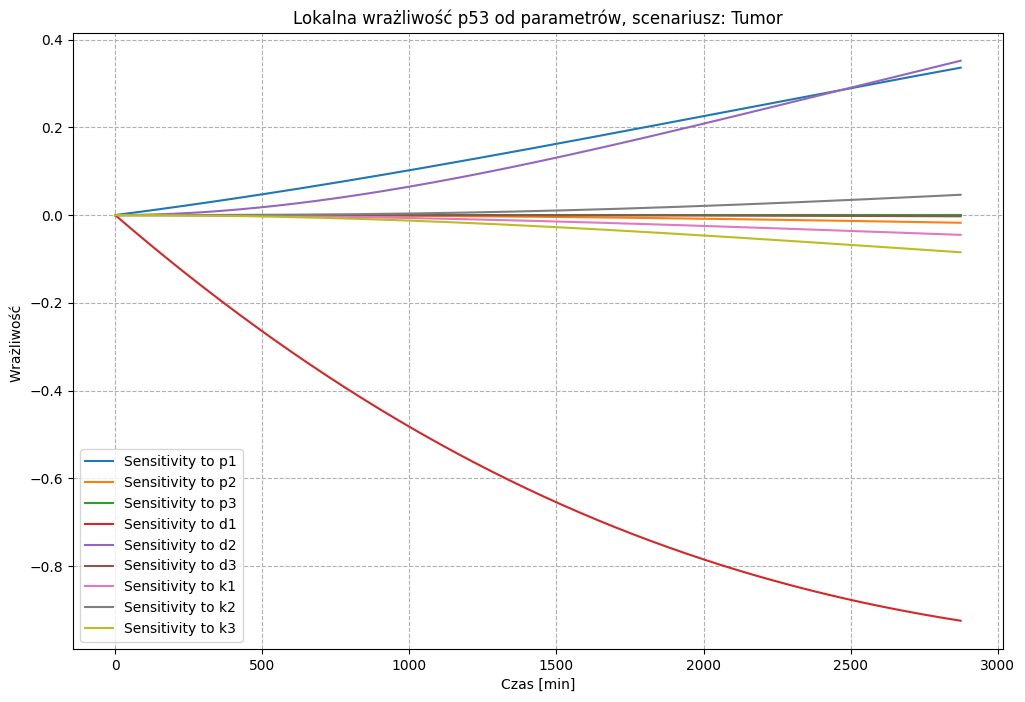

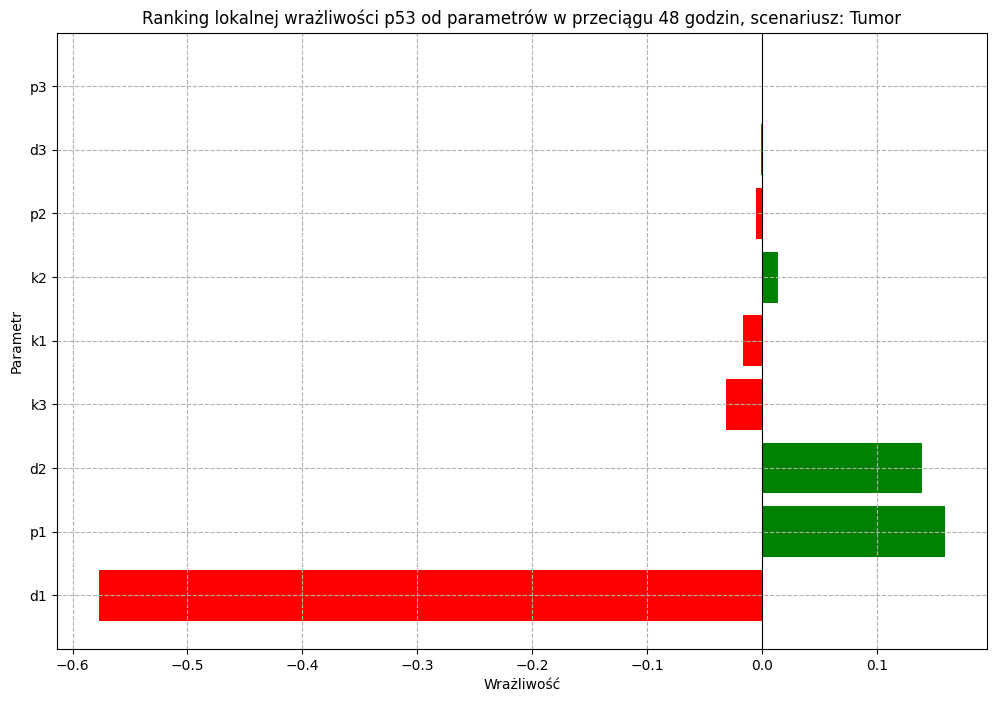

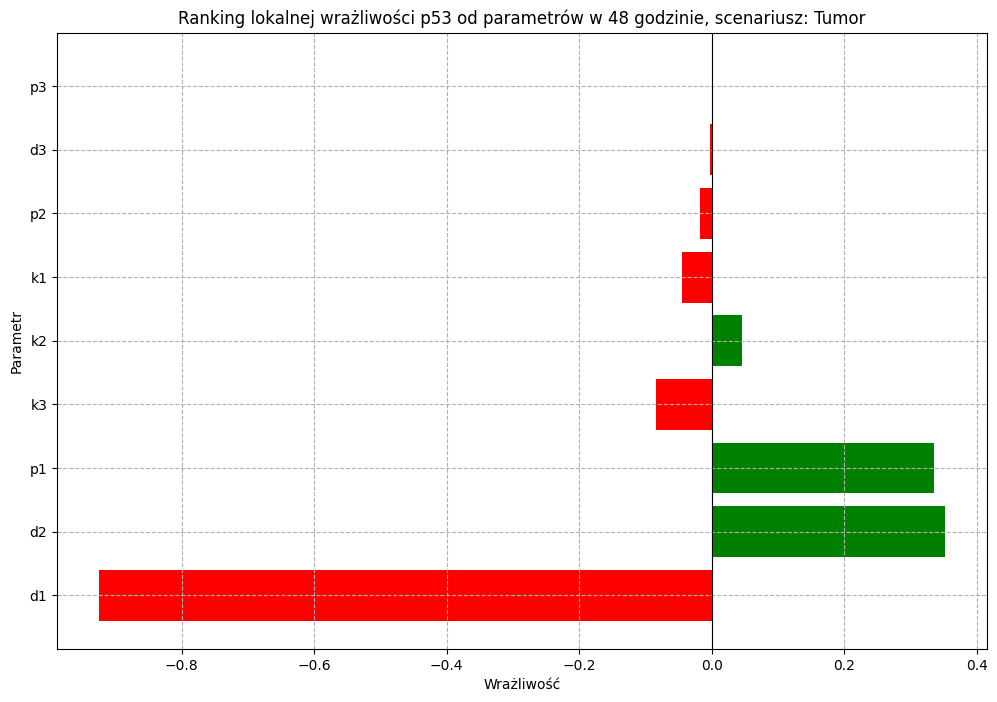

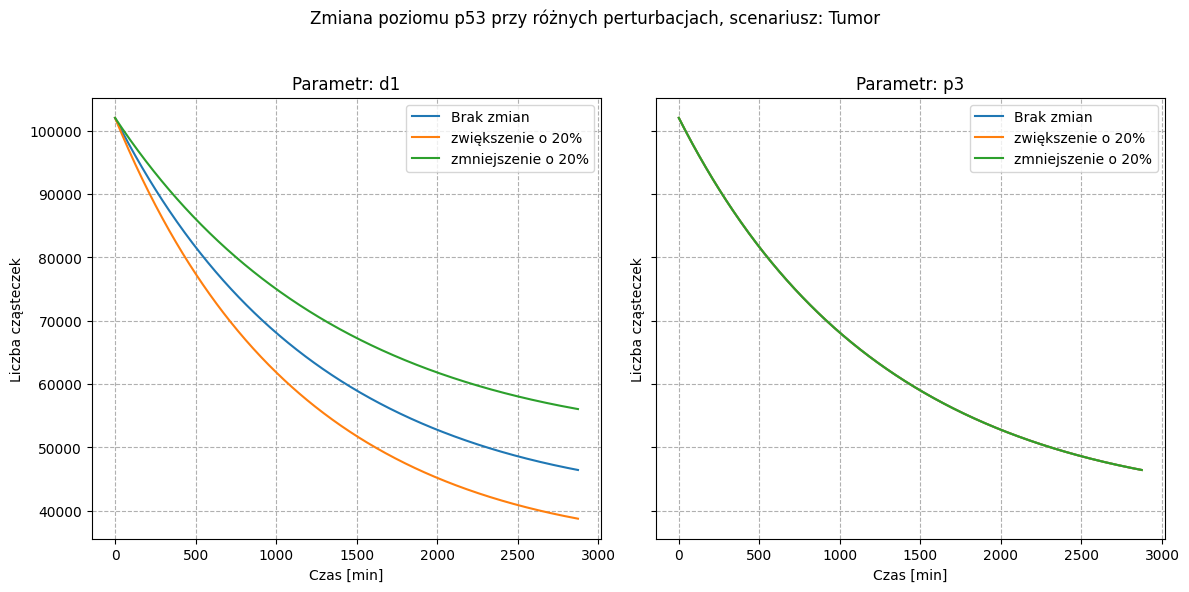

9


In [50]:
def main():
    x = []
    for name, scenario in conditions.items(): 
        t, s, p53_nom = local_sensitivity(params, proteins, scenario)
        ranking1, ranking2 = ranking(s)
        ranking1_keys = [k for k, v in ranking1]
        ranking1_values = [v for k, v in ranking1]
        x.append(ranking1_values)
        ranking2_keys = [k for k, v in ranking2]
        ranking2_values = [v for k, v in ranking2]

        plt.figure(figsize=(12, 8))
        for key in s:
            plt.plot(t, s[key], label=f'Sensitivity to {key}')
        plt.title(f'Lokalna wrażliwość p53 od parametrów, scenariusz: {name}')
        plt.xlabel("Czas [min]")
        plt.ylabel("Wrażliwość ")
        # plt.yscale("log")
        plt.legend()
        plt.grid(True, which="both", ls="--")
        plt.show()        

        plt.figure(figsize=(12, 8))
        plt.barh(ranking1_keys, ranking1_values, color=['green' if v >= 0 else 'red' for v in ranking1_values])
        plt.axvline(0, color='black', linewidth=0.8)
        plt.title(f'Ranking lokalnej wrażliwości p53 od parametrów w przeciągu 48 godzin, scenariusz: {name}')
        plt.xlabel("Wrażliwość")
        plt.ylabel("Parametr")
        plt.grid(True, which="both", ls="--")
        plt.show()

        plt.figure(figsize=(12, 8))
        plt.barh(ranking2_keys, ranking2_values, color=['green' if v >= 0 else 'red' for v in ranking2_values])
        plt.axvline(0, color='black', linewidth=0.8)
        plt.title(f'Ranking lokalnej wrażliwości p53 od parametrów w 48 godzinie, scenariusz: {name}')
        plt.xlabel("Wrażliwość")
        plt.ylabel("Parametr")
        plt.grid(True, which="both", ls="--")
        plt.show()

        change = {
            ranking1[0][0]: [1.2, 0.8],
            ranking1[-1][0]: [1.2, 0.8]
        }
        n_facets = len(change)
        fig, axes = plt.subplots(1, n_facets, figsize=(6 * n_facets, 6), sharey=True)
        for ax, (p, c_values) in zip(axes, change.items()):
            t, p53_perturbed = RK4(params, proteins, scenario, iterations, h)
            ax.plot(t, p53_perturbed[0], label=f'Brak zmian')
            for c in c_values:
                params_perturbed = params.copy()
                params_perturbed[p] = params_perturbed[p] * c
                t, p53_perturbed = RK4(params_perturbed, proteins, scenario, iterations, h)
                ax.plot(t, p53_perturbed[0], label=f'{"zwiększenie" if c > 1 else "zmniejszenie"} o 20%')
            ax.set_title(f'Parametr: {p}')
            ax.set_xlabel("Czas [min]")
            ax.set_ylabel("Liczba cząsteczek")
            ax.legend()
            ax.grid(True, which="both", ls="--")
        plt.suptitle(f'Zmiana poziomu p53 przy różnych perturbacjach, scenariusz: {name}')
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()    
    print(sum(x != y for x, y in zip(x[0], x[1])))

main()

Dla porówniania pozwolę sobie skorzystać z rozwiązań gotowych oferowanych przez pakiet SALib (niby nie mówił Profesor, że nie można korzystać z takich, ale uznaliśmy że nie wypada, więc to tylko kontorlnie):

In [ ]:
from SALib.sample import saltelli
from SALib.analyze import soboldef


model_ode(t, y, siRNA=False, pten_off=False, no_DNA_damage=False):
    p53, mdmcyto, mdmn, pten = y
    dydt = np.zeros(4)
    dydt[0] = f_p53(p53, mdmn)
    dydt[1] = f_mdmcyto(p53, mdmcyto, pten, siRNA=siRNA, no_DNA_damage=no_DNA_damage)
    dydt[2] = f_mdmn(mdmn, mdmcyto, pten, no_DNA_damage=no_DNA_damage)
    dydt[3] = f_pten(pten, p53, pten_off=pten_off)
    return dydt
for scenario in scenarios:
    siRNA, pten_off, no_DNA_damage = conditions[scenario]
    # Definicja zakresu czasu i warunków początkowych
    t_span = (0, 48*60)  # od 0 do 2880 minut (48h)
    y0 = [p53_0, mdmcyto_0, mdmn_0, pten_0]
    t_eval = np.arange(0, 48*60 + h, h)
    sol = solve_ivp(
        model_ode, t_span, y0, method='RK45', t_eval=t_eval,
        args=(siRNA, pten_off, no_DNA_damage)
    )
    plt.figure(figsize=(10,5))
    plt.xlabel("Czas [min]")
    plt.ylabel("Liczba cząsteczek białka")
    plt.title(f"SALibsobol: Liczności białek w 48h w scenariuszu: {scenario}")
    plt.yscale("log")
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()


## 6. Wnioski

1.

---